# 0. Get Started

In [ ]:
import torch
import dlib
import cv2
from os import listdir
from imutils import face_utils
import numpy as np
import imutils

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import random
import string

import pandas as pd
from tqdm import tqdm
import seaborn as sns

import pickle

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [ ]:
file_dir = './drive/My Drive/oculoplastics_diagnosis/'
data_dir = './drive/My Drive/oculoplastics_diagnosis/data/'
img_dir = './drive/My Drive/oculoplastics_diagnosis/data/processed/'
img_dir_normal = './drive/My Drive/oculoplastics_diagnosis/data/processed/normal/'
img_dir_thyroid = './drive/My Drive/oculoplastics_diagnosis/data/processed/normal/thyroid_eye_disease/'

In [ ]:
def display_one(a, title = "Original"):
    plt.imshow(a), plt.title(title)
    plt.xticks([]), plt.yticks([])
    plt.show()

# 1. Cleaning / Cropping & De-identify Images

In [ ]:
def get_random_string(length):
    letters = list(string.ascii_lowercase)
    result_str = ''.join(random.choice(letters) for i in range(length))
    return result_str

In [ ]:
# Predictor file path info
predictor_path = file_dir + 'shape_predictor_68_face_landmarks.dat'
predictor = dlib.shape_predictor(predictor_path)

face_detector = dlib.get_frontal_face_detector()

# Define text info
font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 1
fontColor = (255, 255, 255)
lineType = 2

def predict_landmarks(filepath, predictor):
    """
    Predicting the landmarks given a image filepath and a predictor object
    nput:
        - filepath       : filepath to the image
        - predictor      : predictor object
    return:
        - image          : output image
        - shape          : list of landmark locations
    """

    # load the input image, resize it, and convert it to grayscale
    image = cv2.imread(filepath)
    # image = imutils.resize(image, width = 250)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    rects = face_detector(gray, 1)
    if len(rects) == 0:
        rects = dlib.rectangles()
        h, w = image.shape[0], image.shape[1]
        rec = dlib.rectangle(0, 0, w, h)
        rects.append(rec)

    shape = 0
    # loop over the face detections
    for (i, rect) in enumerate(rects):

        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)
        shape = shape[36:48, :]

        # loop over the (x, y)-coordinates for the facial landmarks
        # and draw them on the image
        # for (x, y) in shape:
        #     cv2.circle(image, (x, y), 50, (0, 0, 255), -1)
    # return cv2.cvtColor(image, cv2.COLOR_BGR2RGB), shape
    return image, shape

- If there are existing images, load their info

In [ ]:
loading_success = False
try:
    old_img_info_df = pd.read_csv(file_dir + 'data/img_info_df.csv')
    if old_img_info_df.shape[0] > 0:
        loading_success = True
except:
    pass

old_img_info_df.shape

(508, 4)

In [ ]:
img_info_dic = []
error_img = []
all_key_set = set([])
# group_name = 'normal'

def clean_group(group_name):
    count = 0
    for f in tqdm(listdir(file_dir + 'data/raw/' + group_name + '/')):
        if '.JPG' not in f:
            continue
        count += 1
        # if count < 91 or count > 100:
        #     continue
        output, shape = predict_landmarks(file_dir + 'data/raw/' + group_name + '/' + f, predictor)
        new_key = get_random_string(20)
        while new_key in all_key_set:
            new_key = get_random_string(20)
        all_key_set.add(new_key)
        new_name = group_name + '_' + new_key + '.JPG'
        tmp_dic = {}
        tmp_dic['original_name'] = f
        tmp_dic['new_name'] = new_name
        tmp_dic['group'] = group_name

        # Cropping
        inter_w = shape[6][0] - shape[3][0]
        left = int(shape[0][0] - inter_w / 2)
        right = int(shape[9][0] + inter_w / 2)
        up = min(shape[:, 1])
        down = max(shape[:, 1])
        inter_h = down - up
        up = up - inter_h
        down = down + inter_h
        output = output[up: down, left: right]
        shape = shape - np.array([left, up])
        tmp_dic['landmark'] = [tuple(i) for i in shape]

        # Saving
        if 0 in output.shape:
            error_img.append(tmp_dic)
            continue
        img_info_dic.append(tmp_dic)
        cv2.imwrite(file_dir + 'data/processed/' + group_name + '/' + new_name, output)
        # for (x, y) in shape:
        #     cv2.circle(output, (x, y), 50, (0, 0, 255), -1)
        # imgplot = plt.imshow(output)
        # plt.show()
        # if count == 5:
        #     break

for group in ['ptosis']:
    clean_group(group)

100%|██████████| 201/201 [40:25<00:00, 12.07s/it]


In [ ]:
img_info_df = pd.DataFrame(img_info_dic)
img_info_df.shape

(201, 4)

In [ ]:
if loading_success:
    img_info_df = pd.concat([img_info_df, old_img_info_df]).reset_index(drop = True)

In [ ]:
img_info_df.shape

(709, 4)

In [ ]:
img_info_df.head(2)

,original_name,new_name,group,landmark
0,02AC08319550-020116-374.33.JPG,ptosis_nvzpclozaoeidsnwdcpv.JPG,ptosis,"[(274, 257), (379, 167), (523, 163), (668, 250..."
1,02AK13979406-060616-374.33.JPG,ptosis_eifbepvvxejylejtpgqb.JPG,ptosis,"[(300, 235), (427, 144), (592, 141), (742, 244..."


In [ ]:
# img_info_df.to_csv(file_dir + 'data/img_info_df.csv', index = False)

In [ ]:
# pd.DataFrame(error_img).to_csv('error_img_df.csv', index = False)

## Filter out the error images
- **MANUAL LABLEING REQUIRED!**
- Before this step, please check `error_img_df.csv` and other potential error images (e.g. images with very little file size). After verifying them, update the `error_img_df.csv` and proceed

In [ ]:
img_info_df = pd.read_csv(file_dir + 'data/img_info_df.csv')
error_img_df = pd.read_csv(file_dir + 'data/error_img_df.csv')
error_img_names = set(error_img_df.new_name.values)

# Construct the needed columns
img_info_df['error'] = img_info_df.new_name.apply(lambda n: 1 if n in error_img_names else 0)
img_info_df['filepath'] = img_info_df.apply(lambda s: s.group + '/' + s.new_name, axis = 1)

In [ ]:
num_error = img_info_df.query('error == 1').shape[0]
num_normal = img_info_df.query('group == "normal" & error == "0"').shape[0]
print('Out of', img_info_df.shape[0], 'images,', num_error, 'were not cleaned/cropped correctly.')
print('Out of', img_info_df.shape[0], 'images,', num_normal, 'were cleaned/cropped correctly AND had a label of "normal eyes".')

Out of 709 images, 18 were not cleaned/cropped correctly.
Out of 709 images, 257 were cleaned/cropped correctly AND had a label of "normal eyes".


In [ ]:
# Drop un-necessary columns
img_info_df = img_info_df.query('error == 0').drop(columns = ['landmark']).reset_index(drop = True)
img_info_df.head()

,original_name,new_name,group,error,filepath
0,02AC08319550-020116-374.33.JPG,ptosis_nvzpclozaoeidsnwdcpv.JPG,ptosis,0,ptosis/ptosis_nvzpclozaoeidsnwdcpv.JPG
1,02AK13979406-060616-374.33.JPG,ptosis_eifbepvvxejylejtpgqb.JPG,ptosis,0,ptosis/ptosis_eifbepvvxejylejtpgqb.JPG
2,02AL30243827-090816-374.33.JPG,ptosis_saykhsfyqqtyolfzfshp.JPG,ptosis,0,ptosis/ptosis_saykhsfyqqtyolfzfshp.JPG
3,02AK12478616-031416-374.33.JPG,ptosis_eunkxhkcinmytgwlybrb.JPG,ptosis,0,ptosis/ptosis_eunkxhkcinmytgwlybrb.JPG
4,02AF30502849-062918-374.33.JPG,ptosis_lfmvjvxpyosmpzquvgup.JPG,ptosis,0,ptosis/ptosis_lfmvjvxpyosmpzquvgup.JPG


In [ ]:
print('Now saving the cleaning result summary sheet with:', img_info_df.shape[0], 'images.')
img_info_df.to_csv(file_dir + 'data/img_info_cleaned_no_error.csv', index = False)

Now saving the cleaning result summary sheet with: 691 images.


# 2. Pre-processing / Preparing Face Data

In [ ]:
img_info_cleaned_no_error = pd.read_csv(file_dir + 'data/img_info_cleaned_no_error.csv')
img_info_cleaned_no_error.head()

,original_name,new_name,group,filepath,label,dataset
0,02AC08319550-020116-374.33.JPG,ptosis_nvzpclozaoeidsnwdcpv.JPG,ptosis,ptosis/ptosis_nvzpclozaoeidsnwdcpv.JPG,2,val
1,02AK13979406-060616-374.33.JPG,ptosis_eifbepvvxejylejtpgqb.JPG,ptosis,ptosis/ptosis_eifbepvvxejylejtpgqb.JPG,2,train
2,02AL30243827-090816-374.33.JPG,ptosis_saykhsfyqqtyolfzfshp.JPG,ptosis,ptosis/ptosis_saykhsfyqqtyolfzfshp.JPG,2,test
3,02AK12478616-031416-374.33.JPG,ptosis_eunkxhkcinmytgwlybrb.JPG,ptosis,ptosis/ptosis_eunkxhkcinmytgwlybrb.JPG,2,train
4,02AM30491425-072718-374.33.JPG,ptosis_hcxzahrepngizofzprqp.JPG,ptosis,ptosis/ptosis_hcxzahrepngizofzprqp.JPG,2,train


In [ ]:
file_dir = './drive/My Drive/oculoplastics_diagnosis/'
img_dir = './drive/My Drive/oculoplastics_diagnosis/data/processed/'
img_dir_normal = './drive/My Drive/oculoplastics_diagnosis/data/processed/normal/'
img_dir_thyroid = './drive/My Drive/oculoplastics_diagnosis/data/processed/normal/thyroid_eye_disease/'

## 2.1 Resize Images

In [ ]:
# img_info_df.to_csv(file_dir + 'data/img_info_cleaned.csv', index = False)
# img_info_cleaned = pd.read_csv(file_dir + 'data/img_info_cleaned.csv')

In [ ]:
processed_img_dir = './drive/My Drive/oculoplastics_diagnosis/data/processed/'

# Function to resize image
def resize_to(desired_size, im_pth):
    im = cv2.imread(im_pth, 0)
    old_size = im.shape[:2] # old_size is in (height, width) format

    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

    # new_size should be in (width, height) format

    im = cv2.resize(im, (new_size[1], new_size[0]))

    delta_w = desired_size - new_size[1]
    delta_h = desired_size // 2 - new_size[0]
    top, bottom = delta_h // 2, delta_h-(delta_h//2)
    left, right = delta_w // 2, delta_w-(delta_w//2)

    color = [0, 0, 0]
    try:
        new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,
            value = color)
        return new_im
    except:
        print('Error at:', im_pth)
        return

In [ ]:
# display_one(resize_to(512, img_dir + 'normal/' + 'normal_rrkbifwnbxdvukfhmvgv.JPG'))

In [ ]:
img_info_cleaned_no_error['resized_img'] = [resize_to(512, img_dir + fp) for fp in tqdm(img_info_cleaned_no_error.filepath)] 

100%|██████████| 690/690 [13:04<00:00,  1.14s/it]


## 2.2 Assigning groups

In [ ]:
def calc_label(group):
    if group == 'normal':
        return 0
    if group == 'thyroid_eye_disease':
        return 1
    if group == 'ptosis':
        return 2
img_info_cleaned_no_error['label'] = img_info_cleaned_no_error.group.apply(calc_label)

## 2.3 Train test split

In [ ]:
prev_shape = img_info_cleaned_no_error.shape[0]
img_info_cleaned_no_error = img_info_cleaned_no_error.dropna().reset_index(drop = True)
curr_shape = img_info_cleaned_no_error.shape[0]
print('Number of images dropped because of NaN:', prev_shape - curr_shape)

Number of images dropped because of NaN: 0


In [ ]:
X = img_info_cleaned_no_error['resized_img'].values
y = img_info_cleaned_no_error['label'].values

all_idx = list(range(len(X)))
X_train_idx, X_test_idx, y_train, y_test = train_test_split(all_idx, y, test_size = 0.3, random_state = 42)
X_train_idx, X_val_idx, y_train, y_val = train_test_split([i for i in all_idx if i not in X_test_idx], y_train, test_size = 0.3, random_state = 42)

# print(len(X_train_idx), len(X_val_idx), len(X_test_idx))

train_idx_dict = dict(zip(range(len(X_train_idx)), X_train_idx))
val_idx_dict = dict(zip(range(len(X_val_idx)), X_val_idx))
test_idx_dict = dict(zip(range(len(X_test_idx)), X_test_idx))

X_train, X_val, X_test = X[X_train_idx], X[X_val_idx], X[X_test_idx]
y_train, y_val, y_test = y[X_train_idx], y[X_val_idx], y[X_test_idx]
# print(X_train.shape, X_val.shape, X_test.shape)

img_info_cleaned_no_error['dataset'] = range(len(X))
def calc_dataset(s):
    if s in X_train_idx:
        return 'train'
    if s in X_val_idx:
        return 'val'
    if s in X_test_idx:
        return 'test'
img_info_cleaned_no_error.dataset = [calc_dataset(idx) for idx in tqdm (img_info_cleaned_no_error.dataset.values)]
print('Split done, resulting in the following:')
print(' Train:', len(y_train))
print(' Val:', len(y_val))
print(' Test:', len(y_test))
img_info_cleaned_no_error.head(2)

100%|██████████| 690/690 [00:00<00:00, 14715.14it/s]

Split done, resulting in the following:
 Train: 338
 Val: 145
 Test: 207


,original_name,new_name,group,filepath,label,dataset,resized_img
0,02AC08319550-020116-374.33.JPG,ptosis_nvzpclozaoeidsnwdcpv.JPG,ptosis,ptosis/ptosis_nvzpclozaoeidsnwdcpv.JPG,2,val,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,02AK13979406-060616-374.33.JPG,ptosis_eifbepvvxejylejtpgqb.JPG,ptosis,ptosis/ptosis_eifbepvvxejylejtpgqb.JPG,2,train,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


## Save training info to local files

In [ ]:
f = open(data_dir + 'pickle/' + 'img_info_cleaned_no_error', 'wb')
pickle.dump(img_info_cleaned_no_error, f)
f.close()

In [ ]:
# img_info_cleaned_no_error = img_info_cleaned_no_error.drop(columns = ['resized_img'])
img_info_cleaned_no_error.to_csv(file_dir + 'data/img_info_cleaned_no_error.csv', index = False)

In [ ]:
f = open(data_dir + 'pickle/' + 'X_train', 'wb')
pickle.dump(X_train, f)
f.close()

f = open(data_dir + 'pickle/' + 'X_val', 'wb')
pickle.dump(X_val, f)
f.close()

f = open(data_dir + 'pickle/' + 'X_test', 'wb')
pickle.dump(X_test, f)
f.close()


f = open(data_dir + 'pickle/' + 'y_train', 'wb')
pickle.dump(y_train, f)
f.close()

f = open(data_dir + 'pickle/' + 'y_val', 'wb')
pickle.dump(y_val, f)
f.close()

f = open(data_dir + 'pickle/' + 'y_test', 'wb')
pickle.dump(y_test, f)
f.close()

f = open(data_dir + 'pickle/' + 'train_idx_dict', 'wb')
pickle.dump(train_idx_dict, f)
f.close()

f = open(data_dir + 'pickle/' + 'test_idx_dict', 'wb')
pickle.dump(test_idx_dict, f)
f.close()

f = open(data_dir + 'pickle/' + 'val_idx_dict', 'wb')
pickle.dump(val_idx_dict, f)
f.close()

In [5]:
# tmp = pickle.load(open(data_dir + 'pickle/' + 'img_info_cleaned_no_error', 'rb'))
# tmp.head()

In [ ]:
(tmp.resized_img.iloc[0])

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

# 3. Linear Model

In [ ]:
from sklearn.model_selection import train_test_split

## Train-test split

In [ ]:

# X_raw = img_info_cleaned['resized_img'].apply(lambda x: x.reshape(1, x.shape[0] * x.shape[1])[0]).values
X_raw = list(img_info_cleaned['resized_img'].apply(lambda x: list(x.flatten())).values)

X = np.array(X_raw)
y = img_info_cleaned['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3, random_state = 42)

NameError: ignored

In [ ]:
print(X_train.shape, X_val.shape, X_test.shape)

## Model Selection

In [ ]:
#importing all the required ML packages
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn import svm #support vector Machine
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.tree import DecisionTreeClassifier #Decision Tree
from sklearn.naive_bayes import GaussianNB #Naive bayes

from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix

In [ ]:
# LogisticRegression
acc_df = []
for i in [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]:
    model = LogisticRegression(C = i, max_iter = 1000) 
    model.fit(X_train, y_train)
    prediction = model.predict(X_val)
    acc_df.append({
        'c': i,
        'acc': (metrics.accuracy_score(prediction, y_val))
    })
best_c_log = pd.DataFrame(acc_df).sort_values(by = 'acc', ascending = False).iloc[0].c

# Test best model
model = LogisticRegression(C = best_c_log, max_iter = 1000) 
model.fit(X_train, y_train)
prediction = model.predict(X_val)
print('Best acc of LogReg:', (metrics.accuracy_score(prediction, y_val)))

In [ ]:
prediction = model.predict(X_test)
print('Val acc for Logistic Regression is ', metrics.accuracy_score(prediction, y_test))

# 4. Neuro model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader, TensorDataset, RandomSampler, SequentialSampler
import torch.optim as optim
from datetime import date

In [ ]:
# config = {
#     'model_idx': 1,
#     'curr_label': 'label_ptosis',
#     'data_pkl_dir': data_dir + 'pickle/' + 'img_info_cleaned_no_error',
#     'class_num': 2,
#     'chann1': 4,
#     'chann2': 16,
#     'chann3': 64,
#     'mid_dim': 512,
#     'dropout': 0.4,
#     'batch_size': 20,
#     'n_epochs': 2000,
#     'from_checkpoint': 0
# }
# config['model_name'] = str(date.today()) + '-' + str(config['model_idx'])

In [ ]:
f = open(data_dir + 'pickle/' + 'img_info_cleaned_no_error', 'rb')
img_info_cleaned_no_error = pickle.load(f).reset_index(drop = True)
f.close()
# img_info_cleaned_no_error['img_idx'] = range(img_info_cleaned_no_error.shape[0])
img_info_cleaned_no_error.head(2)

,original_name,new_name,group,filepath,label,dataset,resized_img,label_ptosis,label_ted,img_idx
0,02AC08319550-020116-374.33.JPG,ptosis_nvzpclozaoeidsnwdcpv.JPG,ptosis,ptosis/ptosis_nvzpclozaoeidsnwdcpv.JPG,2,val,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1,0,0
1,02AK13979406-060616-374.33.JPG,ptosis_eifbepvvxejylejtpgqb.JPG,ptosis,ptosis/ptosis_eifbepvvxejylejtpgqb.JPG,2,train,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1,0,1


In [ ]:
# img_info_cleaned_no_error['label_ptosis'] = img_info_cleaned_no_error.group.apply(lambda g: 1 if g == 'ptosis' else 0)
# img_info_cleaned_no_error['label_ted'] = img_info_cleaned_no_error.group.apply(lambda g: 1 if g == 'thyroid_eye_disease' else 0)
pickle.dump(img_info_cleaned_no_error, open(data_dir + 'pickle/' + 'img_info_cleaned_no_error', 'wb'))

In [ ]:
img_info_cleaned_no_error.resized_img.iloc[0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
# .astype(float16)

In [ ]:
# torch.tensor([i for i in img_info_cleaned_no_error.resized_img.values])

In [ ]:
# torch.tensor([torch.tensor(i.numpy()) for i in train_df.resized_img.values])

## 4.1 Model Definition

In [ ]:
class Trainer():
    def __init__(self, config):
        self.data_pkl_dir = config['data_pkl_dir']      
        # config['original_size'] = self.data.resized_img.iloc[0].shape
        self.original_size = config['original_size']
        # self.model = DiagnoisisNet(config)
        self.batch_size = config['batch_size']
        self.curr_label = config['curr_label']
        self.class_num = config['class_num']
        self.n_epochs = config['n_epochs']
        self.from_checkpoint = config['from_checkpoint']
        
        self.model_name = config['model_name']

        self.training_log = file_dir + 'models/training_log.txt'
        self.testing_log = file_dir + 'models/testing_log.txt' 

        self.training_log_lst = []

    def dataloader_prep(self, df, train = False):
        data_set = TensorDataset(torch.tensor(df[self.curr_label].values), 
                                 torch.tensor([i for i in df.resized_img.values]), 
                                 torch.tensor(df.img_idx.values))
        if train:
            return DataLoader(data_set, sampler = RandomSampler(data_set), batch_size = self.batch_size)
        else:
            return DataLoader(data_set, sampler = SequentialSampler(data_set), batch_size = self.batch_size)

    
    def data_prep(self):
        data_file = open(self.data_pkl_dir, 'rb')
        data = pickle.load(data_file)
        # data_file.close()
        train_df = data.query('dataset == "train"')
        val_df = data.query('dataset == "val"')
        test_df = data.query('dataset == "test"')
        # display(train_df)

        # dataset_train = 
        # dataset_val = TensorDataset(torch.tensor(val_df.resized_img), 
        #                             torch.tensor(val_df[self.curr_label]), 
        #                             torch.tensor(val_df.img_idx))
        # dataset_test = TensorDataset(torch.tensor(test_df.resized_img), 
        #                              torch.tensor(test_df[self.curr_label]), 
        #                              torch.tensor(test_df.img_idx))

        train_dataloader = self.dataloader_prep(train_df, train = True)
        val_dataloader = self.dataloader_prep(val_df)
        test_dataloader = self.dataloader_prep(test_df)
        return train_dataloader, val_dataloader, test_dataloader

    def train(self):
        # Data preparation
        train_dataloader, val_dataloader, test_dataloader = self.data_prep()
        
        # create a complete CNN
        model = DiagnoisisNet(config)
        # print(model)
        # move tensors to GPU if CUDA is available
        if torch.cuda.is_available():
            print('Using cuda!')
            model.cuda()
        # specify loss function (categorical cross-entropy)
        criterion = nn.CrossEntropyLoss()
        # specify optimizer
        optimizer = optim.Adam(model.parameters(), lr=0.00001)
        # optimizer = optim.SGD(model.parameters(), lr=0.00001)
        # train_on_gpu = torch.cuda.is_available()

        valid_loss_min = np.Inf # track change in validation loss

        starting_epoch = self.from_checkpoint + 1
        best_test_acc = 0
        for epoch in tqdm(range(starting_epoch, starting_epoch + self.n_epochs)):

            # keep track of training and validation loss
            train_loss = 0.0
            valid_loss = 0.0
            
            ###################
            # train the model #
            ###################
            model.train()

            # indices = torch.randperm(len(X_train), dtype = torch.long, device = 'cpu')
            # train_dataloader = torch.utils.data.DataLoader(indices, batch_size = batch_size)
            train_pred = []
            train_label = []
            train_scores = []
            for batch in train_dataloader:
                data, label, img_names = batch
                # move tensors to GPU if CUDA is available
                if train_on_gpu:
                    data, target = data.cuda(), target.cuda()
                # clear the gradients of all optimized variables
                optimizer.zero_grad()
                # forward pass: compute predicted outputs by passing inputs to the model
                output = model(data)

                # print(output.shape, target.shape)
                # calculate the batch loss
                loss = criterion(output, target)
                # backward pass: compute gradient of the loss with respect to model parameters
                loss.backward()
                # perform a single optimization step (parameter update)
                optimizer.step()
                # update training loss
                train_loss += loss.item() * data.size(0)
                output_scores = output.to('cpu').detach().numpy()
                output = np.argmax(output_scores, axis = 1).flatten()
                for o in output:
                    train_pred.append(o)
                for s in output_scores:
                    train_scores.append(s)
                for t in target:
                    train_label.append(t)
            train_acc = output_analysis(np.array(train_pred), np.array(train_label))['acc']

            ######################    
            # validate the model #
            ######################
            model.eval()
            indices = list(range(len(X_val)))
            test_dataloader = torch.utils.data.DataLoader(indices, batch_size = batch_size)
            test_pred = []
            test_label = []
            test_scores = []
            for batch in test_dataloader:
                data, label, img_names = batch
                # move tensors to GPU if CUDA is available
                if train_on_gpu:
                    data, target = data.cuda(), target.cuda()
                # forward pass: compute predicted outputs by passing inputs to the model
                with torch.no_grad():
                    output = model(data)
                # calculate the batch loss
                
                loss = criterion(output, target)
                # update average validation loss 
                valid_loss += loss.item()*data.size(0)
                # Update for acc
                output_scores = output.to('cpu').detach().numpy()
                output = np.argmax(output_scores, axis = 1).flatten()
                for o in output:
                    test_pred.append(o)
                for s in output_scores:
                    test_scores.append(s)
                for t in target:
                    test_label.append(t)
            test_acc = output_analysis(np.array(test_pred), np.array(test_label))['acc']

            # calculate average losses
            train_loss = train_loss/len(X_train)
            valid_loss = valid_loss/len(X_val)
            
            # if epoch % 10 == 0:
            #     # print training/validation statistics 
            #     print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            #         epoch, train_loss, valid_loss))
            #     print('Train acc:', train_acc, '; vali acc:', test_acc)
            
            # save model if validation loss has decreased
            if test_acc > best_test_acc:
                torch.save(model.state_dict(), 'tmp_model.pt')
                best_test_acc = test_acc
            tmp_summary_dict = {}
            tmp_summary_dict['epoch'] = epoch
            tmp_summary_dict['val_acc'] = test_acc
            tmp_summary_dict['train_acc'] = train_acc
            tmp_summary_dict['train_loss'] = train_loss
            tmp_summary_dict['valid_loss'] = valid_loss
            self.training_log_lst.append(tmp_summary_dict)
        training_summary_df = pd.DataFrame(self.training_log_lst)

        model = DiagnoisisNet(class_num = 3)
        model.load_state_dict(torch.load('tmp_model.pt'))
        test_acc = self.run_single_test(model, test_dataloader, return_prediction_dict = False)
        torch.save(model.state_dict(), file_dir + 'models/model_' + self.model_name + '.pt')
        return training_summary_df, test_acc

    def run_single_test(self, model, dataloader, return_prediction_dict = True):
        model.cuda()
        model.eval()
        print()
        print(" => Running Testing...")

        nb_eval_steps, nb_eval_examples = 0, 0
        test_label = []
        test_pred = []
        test_scores = []
        all_prediction_dict = {}
        first_batch = True
        # Evaluate data for one epoch
        for batch in tqdm(test_dataloader):

            data, label, img_names = batch
             # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            with torch.no_grad():
                output = model(data)
    
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
            # Update for acc
            output_scores = output.to('cpu').detach().numpy()
            output = np.argmax(output_scores, axis = 1).flatten()
            for o in output:
                test_pred.append(o)
            for s in output_scores:
                test_scores.append(s)
            for t in target:
                test_label.append(t)

            for i in range(len(img_names)):
                all_prediction_dict[img_names[i]] = [output_scores[i], output[i]]
        test_acc = output_analysis(np.array(test_pred), np.array(test_label))['acc']
        
        if return_prediction_dict:
            return test_acc, all_prediction_dict
        else:
            return test_acc

# define the CNN architecture
class DiagnoisisNet(nn.Module):
    def __init__(self, config):
        super(DiagnoisisNet, self).__init__()
        self.original_w, self.original_h = config['original_size']
        self.chann1 = config['chann1']
        self.chann2 = config['chann2']
        self.chann3 = config['chann3']
        self.mid_dim = config['mid_dim']
        self.class_num = config['class_num']

        self.conv1 = nn.Conv2d(1, self.chann1, 3, padding = 1)
        self.conv2 = nn.Conv2d(self.chann1, self.chann2, 3, padding = 1)
        self.conv3 = nn.Conv2d(self.chann2, self.chann3, 3, padding = 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(self.chann3 * self.original_w * self.original_h, self.mid_dim)
        self.fc2 = nn.Linear(self.mid_dim, self.class_num)
        self.dropout = nn.Dropout(config['dropout'])

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # print(x.shape)
        x = x.view(-1, self.chann3 * self.original_w * self.original_h)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

def output_analysis(pred, targets):
    pred = np.array(pred)
    targets = np.array([int(i.to('cpu')) for i in targets])
    acc = accuracy_score(targets, pred)
    return {
        'acc': round(100 * acc, 2)
    }

In [ ]:
T = Trainer(config)
T.train()
# T.curr_label

NameError: ignored

In [ ]:
# # define the CNN architecture
# class DiagnoisisNet(nn.Module):
#     def __init__(self, class_num):
#         super(DiagnoisisNet, self).__init__()
#         # convolutional layer (sees 32x32x3 image tensor)
#         self.conv1 = nn.Conv2d(1, 4, 3, padding = 1)
#         # convolutional layer (sees 16x16x16 tensor)
#         self.conv2 = nn.Conv2d(4, 16, 3, padding = 1)
#         # # convolutional layer (sees 8x8x32 tensor)
#         self.conv3 = nn.Conv2d(16, 64, 3, padding = 1)
#         # max pooling layer
#         self.pool = nn.MaxPool2d(2, 2)

#         self.fc1 = nn.Linear(64 * 32 * 64, 512)

#         self.fc2 = nn.Linear(512, class_num)
#         # dropout layer (p=0.4)
#         self.dropout = nn.Dropout(0.4)


#     def forward(self, x):
#         # add sequence of convolutional and max pooling layers
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = self.pool(F.relu(self.conv3(x)))
#         print(x.shape)
#         # flatten image input
#         x = x.view(-1, 64 * 32 * 64)
#         # add dropout layer
#         x = self.dropout(x)
#         # add 1st hidden layer, with relu activation function
#         x = F.relu(self.fc1(x))
#         # add dropout layer
#         x = self.dropout(x)
#         # add 2nd hidden layer, with relu activation function
#         x = self.fc2(x)
#         return x

# def output_analysis(pred, targets):
#     pred = np.array(pred)
#     targets = np.array([int(i.to('cpu')) for i in targets])
#     acc = accuracy_score(targets, pred)
#     return {
#         'acc': round(100 * acc, 2)
#     }

## 4.1 Model Training

- **Setting current label!**

In [ ]:
# current_label = 'label_ptosis'

In [ ]:
# img_info_cleaned_no_error.resized_img.iloc[0].shape

In [ ]:
# img_info_cleaned_no_error.head()

In [ ]:
# sum(X_train[0] != img_info_cleaned_no_error.resized_img.values[4])

In [ ]:
# f = open(data_dir + 'pickle/' + 'X_train', 'rb')
# X_train = pickle.load(f)
# f.close()

In [ ]:
# type(X_train), len(X_train)

In [ ]:
# f = open(data_dir + 'pickle/' + 'train_idx_dict', 'rb')
# train_idx_dict = pickle.load(f)
# f.close()
# # train_idx_dict

In [ ]:
# f = open(data_dir + 'pickle/' + 'X_train', 'rb')
# X_train = pickle.load(f)
# f.close()

# f = open(data_dir + 'pickle/' + 'X_val', 'rb')
# X_val = pickle.load(f)
# f.close()

# f = open(data_dir + 'pickle/' + 'X_test', 'rb')
# X_test = pickle.load(f)
# f.close()

# f = open(data_dir + 'pickle/' + 'y_train', 'rb')
# y_train = pickle.load(f)
# f.close()

# f = open(data_dir + 'pickle/' + 'y_val', 'rb')
# y_val = pickle.load(f)
# f.close()

# f = open(data_dir + 'pickle/' + 'y_test', 'rb')
# y_test = pickle.load(f)
# f.close()

# f = open(data_dir + 'pickle/' + 'train_idx_dict', 'rb')
# train_idx_dict = pickle.load(f)
# f.close()

# f = open(data_dir + 'pickle/' + 'val_idx_dict', 'rb')
# val_idx_dict = pickle.load(f)
# f.close()

# f = open(data_dir + 'pickle/' + 'test_idx_dict', 'rb')
# test_idx_dict = pickle.load(f)
# f.close()

# print(X_train.shape, X_val.shape, X_test.shape)
# print(y_train.shape, y_val.shape, y_test.shape)

In [ ]:
# sum(y_train) / len(y_train)

In [ ]:
# img_info_cleaned_no_error = pd.read_csv(file_dir + 'data/img_info_cleaned_no_error.csv')
# img_info_cleaned_no_error.head()

In [ ]:
# img_info_cleaned_no_error.shape

In [ ]:
# X_train = torch.tensor(np.array([i for i in X_train]))
# X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1], X_train.shape[2])).float()

# X_val = torch.tensor(np.array([i for i in X_val]))
# X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1], X_val.shape[2])).float()

# X_test = torch.tensor(np.array([i for i in X_test]))
# X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])).float()

# y_train = torch.tensor(y_train)
# y_val = torch.tensor(y_val)
# y_test = torch.tensor(y_test)

In [ ]:
# X_train.shape

In [ ]:
# # number of subprocesses to use for data loading
# num_workers = 0
# # how many samples per batch to load
# batch_size = 20
# # percentage of training set to use as validation
# # valid_size = 0.2

In [ ]:
# # create a complete CNN
# model = DiagnoisisNet(class_num = 3)
# print(model)

# # move tensors to GPU if CUDA is available
# if torch.cuda.is_available():
#     print('Using cuda!')
#     model.cuda()

# # specify loss function (categorical cross-entropy)
# criterion = nn.CrossEntropyLoss()

# # specify optimizer
# optimizer = optim.Adam(model.parameters(), lr=0.00001)
# # optimizer = optim.SGD(model.parameters(), lr=0.00001)

# train_on_gpu = torch.cuda.is_available()

In [ ]:
# # number of epochs to train the model
# n_epochs = 2000

# valid_loss_min = np.Inf # track change in validation loss

# best_test_acc = 0
# for epoch in tqdm(range(1, n_epochs + 1)):

#     # keep track of training and validation loss
#     train_loss = 0.0
#     valid_loss = 0.0
    
#     ###################
#     # train the model #
#     ###################
#     model.train()

#     indices = torch.randperm(len(X_train), dtype = torch.long, device = 'cpu')
#     train_dataloader = torch.utils.data.DataLoader(indices, batch_size = batch_size)
#     train_pred = []
#     train_label = []
#     train_scores = []
#     for idx in train_dataloader:
#         data, target = X_train[idx], y_train[idx]
#         # move tensors to GPU if CUDA is available
#         if train_on_gpu:
#             data, target = data.cuda(), target.cuda()
#         # clear the gradients of all optimized variables
#         optimizer.zero_grad()
#         # forward pass: compute predicted outputs by passing inputs to the model
#         output = model(data)

#         # print(output.shape, target.shape)
#         # calculate the batch loss
#         loss = criterion(output, target)
#         # backward pass: compute gradient of the loss with respect to model parameters
#         loss.backward()
#         # perform a single optimization step (parameter update)
#         optimizer.step()
#         # update training loss
#         train_loss += loss.item()*data.size(0)
#         output_scores = output.to('cpu').detach().numpy()
#         output = np.argmax(output_scores, axis = 1).flatten()
#         for o in output:
#             train_pred.append(o)
#         for s in output_scores:
#             train_scores.append(s)
#         for t in target:
#             train_label.append(t)
#     train_acc = output_analysis(np.array(train_pred), np.array(train_label))['acc']

#     ######################    
#     # validate the model #
#     ######################
#     model.eval()
#     indices = list(range(len(X_val)))
#     test_dataloader = torch.utils.data.DataLoader(indices, batch_size = batch_size)
#     test_pred = []
#     test_label = []
#     test_scores = []
#     for idx in test_dataloader:
#         data, target = X_val, y_val
#         # move tensors to GPU if CUDA is available
#         if train_on_gpu:
#             data, target = data.cuda(), target.cuda()
#         # forward pass: compute predicted outputs by passing inputs to the model
#         output = model(data)
#         # calculate the batch loss
        
#         loss = criterion(output, target)
#         # update average validation loss 
#         valid_loss += loss.item()*data.size(0)
#         # Update for acc
#         output_scores = output.to('cpu').detach().numpy()
#         output = np.argmax(output_scores, axis = 1).flatten()
#         for o in output:
#             test_pred.append(o)
#         for s in output_scores:
#             test_scores.append(s)
#         for t in target:
#             test_label.append(t)
#     test_acc = output_analysis(np.array(test_pred), np.array(test_label))['acc']

#     # calculate average losses
#     train_loss = train_loss/len(X_train)
#     valid_loss = valid_loss/len(X_val)
    
#     # if epoch % 10 == 0:
#     #     # print training/validation statistics 
#     #     print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
#     #         epoch, train_loss, valid_loss))
#     #     print('Train acc:', train_acc, '; vali acc:', test_acc)
    
#     # save model if validation loss has decreased
#     if test_acc > best_test_acc:
#         torch.save(model.state_dict(), 'model_cifar.pt')
#         best_test_acc = test_acc

In [ ]:
# model = DiagnoisisNet(class_num = 3)
# model.load_state_dict(torch.load('model_cifar.pt'))
# torch.save(model.state_dict(), file_dir + 'models/model_cifar.pt')

- New trainer used below

In [ ]:
config = {
    'model_idx': 1,
    'curr_label': 'label_ptosis',
    'data_pkl_dir': data_dir + 'pickle/' + 'img_info_cleaned_no_error',
    'class_num': 2,
    'chann1': 4,
    'chann2': 16,
    'chann3': 64,
    'mid_dim': 512,
    'dropout': 0.4,
    'batch_size': 20,
    'n_epochs': 2000,
    'from_checkpoint': 0,
    'original_size': (256, 512)
}
config['model_name'] = str(date.today()) + '-' + str(config['model_idx'])

In [ ]:
T = Trainer(config)
T.train()

TypeError: ignored

## 4.2 Model Testing

In [ ]:
model = DiagnoisisNet(class_num = 3)
model.load_state_dict(torch.load(file_dir + 'models/model_cifar.pt'))
model.eval()

DiagnoisisNet(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=131072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=3, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)

In [ ]:
output_train = model(X_train)
train_scores = output_train.detach().numpy()
output_train = np.argmax(train_scores, axis = 1).flatten()
output_analysis(output_train, y_train)['acc']

100.0

In [ ]:
output_val = model(X_val)
val_scores = output_val.detach().numpy()
output_val = np.argmax(val_scores, axis = 1).flatten()
output_analysis(output_val, y_val)['acc']

74.48

In [ ]:
output_test = model(X_test)
test_scores = output_test.detach().numpy()
output_test = np.argmax(test_scores, axis = 1).flatten()
output_analysis(output_test, y_test)['acc']

74.4

In [ ]:
output_test

array([0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 2, 1, 1, 1, 1, 1, 2, 1, 0, 2, 2,
       0, 1, 0, 0, 0, 2, 1, 1, 2, 1, 1, 2, 1, 0, 0, 1, 0, 2, 0, 2, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 2, 0, 2, 1, 0, 1, 0, 1, 1, 2, 1, 0, 1, 0, 1,
       0, 2, 2, 2, 0, 2, 0, 0, 0, 1, 2, 0, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 1, 0, 2, 1, 1, 2, 1, 1, 0, 1, 2, 0, 0, 1, 2, 2, 1, 2, 1, 2,
       2, 0, 0, 2, 2, 0, 0, 2, 0, 2, 0, 0, 1, 1, 1, 0, 1, 1, 1, 2, 2, 1,
       2, 0, 0, 2, 2, 1, 2, 2, 2, 2, 0, 1, 0, 0, 0, 1, 2, 1, 1, 1, 2, 2,
       1, 2, 2, 0, 0, 1, 0, 0, 0, 2, 2, 0, 0, 1, 2, 0, 1, 0, 2, 1, 1, 0,
       1, 1, 1, 0, 1, 2, 0, 1, 0, 0, 2, 2, 0, 1, 2, 1, 1, 1, 0, 2, 2, 2,
       2, 2, 0, 0, 0, 2, 2, 1, 1])

In [ ]:
sftmax = nn.Softmax(dim = 1)

train_scores = sftmax(torch.tensor(train_scores))
val_scores = sftmax(torch.tensor(val_scores))
test_scores = sftmax(torch.tensor(test_scores))

In [ ]:
round(float(max(train_scores[0])), 2)

0.93

In [ ]:
all_prediction = np.zeros(len(output_test) + len(output_train) + len(output_val))
all_scores = np.zeros(len(all_prediction))
for i in range(len(X_train)):
    all_prediction[train_idx_dict[i]] = output_train[i]
    all_scores[train_idx_dict[i]] = round(float(max(train_scores[i])), 2)
for i in range(len(X_val)):
    all_prediction[val_idx_dict[i]] = output_val[i]
    all_scores[val_idx_dict[i]] = round(float(max(val_scores[i])), 2)
for i in range(len(X_test)):
    all_prediction[test_idx_dict[i]] = output_test[i]
    all_scores[test_idx_dict[i]] = round(float(max(test_scores[i])), 2)

img_info_cleaned['all_scores'] = all_scores
img_info_cleaned['all_prediction'] = all_prediction

In [ ]:
img_info_cleaned['correct'] = img_info_cleaned.apply(lambda s: 1 if s.all_prediction == s.label else 0, axis = 1)

In [ ]:
# img_info_cleaned.to_csv(file_dir + 'data/img_info_cleaned.csv', index = False)

## Score analysis
- Statistical distribution
- Statistical tests
- Outliers

In [ ]:
img_info_cleaned = pd.read_csv(file_dir + 'data/img_info_cleaned.csv')
img_info_cleaned.head()

NameError: ignored

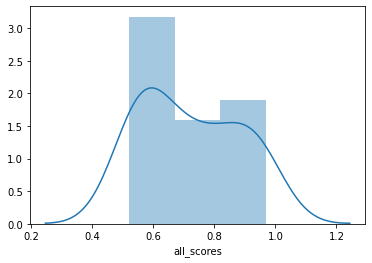

In [ ]:
sns.distplot(img_info_cleaned.query('dataset == "test" & correct == 0').all_scores)

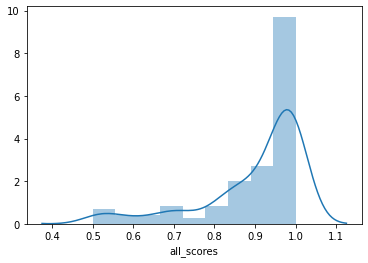

In [ ]:
sns.distplot(img_info_cleaned.query('dataset == "test" & correct == 1').all_scores)

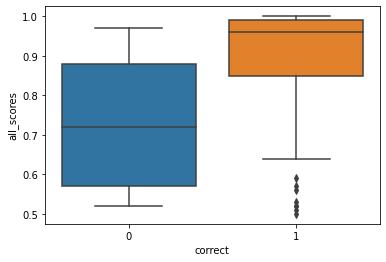

In [ ]:
sns.boxplot(x = 'correct', y = 'all_scores', data = img_info_cleaned.query('dataset == "test"'))

In [ ]:
import scipy

scipy.stats.ks_2samp(img_info_cleaned.query('dataset == "test" & correct == 0').all_scores, img_info_cleaned.query('dataset == "test" & correct == 1').all_scores)

Ks_2sampResult(statistic=0.5396825396825397, pvalue=2.4950139819068795e-05)

## Error case analysis

In [3]:
# img_info_cleaned.query('dataset == "test" & correct == 0').sort_values(by = 'all_scores', ascending = False)\
#     [['original_name', 'new_name', 'label', 'all_prediction', 'all_scores']]

In [2]:
# high_score_failures = img_info_cleaned.query('dataset == "test" & correct == 0').sort_values(by = 'all_scores', ascending = False)\
#     [['original_name', 'new_name', 'label', 'all_prediction', 'all_scores']].query('all_scores > 0.8').reset_index(drop = True)
# high_score_failures

In [1]:
# for i in range(high_score_failures.shape[0]):
#     file_name = high_score_failures.new_name.iloc[i]
#     file_path = '_'.join(file_name.split('_')[:-1])
#     img_path = data_dir + 'processed/' + file_path + '/' + file_name
#     # print(data_dir + file_path + '/' + file_name)
#     img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
#     display_one(img, file_path)

# End